In [346]:
import matplotlib.pyplot as plt
import numpy as np
import numba
import random
from numba import jit
import time
import dask 
from dask import delayed
from collections import deque
from matplotlib.collections import LineCollection
import matplotlib.cm as cm
from matplotlib.animation import FuncAnimation
import pandas as pd
import scipy

In [347]:
import plotly.express as px

Effective stimulus ( $v$ ) follows the Michaelis-Menten Equation:

$$ v = \frac{ v_{max} * S }{ K_d + S} $$

Where:
$v_{max}$ is the maximum possible effective stimulus defined as a funciton of the number of 
receptors ( $nR$ ) a cell has and the catalytic rate constant (degradation rate per receptor) ($K_{cat}$)

default: 
- $ nR = 100$ 
- $k_{cat} = 0.4$ 

$K_d = \frac{k_{off} } {k_{on} }$, defined as a global variables in simulation portion of the code

$S$ is the chemoattractant concentration



In [348]:
def getEffectiveStimulus(v_max, S, K_d):
    '''
    Calculates the effective stimulus (or degree to which the cell is affected by a chemoattractant) 
    according to the relative concentration of the chemoattractant of the cell as well as 
    it's saturation coefficient and the Michaelis-Menten constant.

    Parameters:
        cell (Cell): The cell object to calculate the effective stimulus for where 
            cell.v_max is the maximum reaction of the cell which is determined by the number of 
            receptors the cell is instantiateed with as well as single receptor sensitivity, also
            defined on cell instantiation,
        S (float): The concentration of the chemoattractant at the cell's position.
        K_d (float): The Michaelis-Menten constant defined by k_off / k_on which are 
            defined as global variables 
    
    Returns:
        v (float): The effective stimulus
    '''
    
    v = (v_max * S) / (K_d + S)
    return v

In [349]:
def circle_points(center, radius):
    """
    Calculate all points within a circle in a 2D grid using a rasterization approach,
    returning the points as an array of arrays.

    Parameters:
        center (tuple): The (x, y) coordinates of the circle's center.
        radius (int): Radius of the circle.
    
    Returns:
        list: A list of [x, y] points inside the circle.
    """
    cx, cy = center
  #  radius_squared = radius ** 2
    points = []

    # Use the midpoint circle algorithm to find points
    x, y = radius, 0
    decision = 1 - radius

    while x >= y:
        # Add the points for each octant of the circle as lists
        points.extend([
            [cx + x, cy + y], [cx - x, cy + y], [cx + x, cy - y], [cx - x, cy - y],
            [cx + y, cy + x], [cx - y, cy + x], [cx + y, cy - x], [cx - y, cy - x]
        ])

        y += 1
        if decision <= 0:
            decision += 2 * y + 1
        else:
            x -= 1
            decision += 2 * (y - x) + 1

    # Filter points to ensure they are within the bounds of the grid (optional)
    points = [list(item) for item in set(tuple(point) for point in points)]  # Remove duplicates
    return np.array(points)

In [350]:
@jit(nopython=True)
def _compute_gradient(pos_x, pos_y, u, dx, dy, step = 1):
    '''
    Compute the gradient of a field u at a given position (pos_x, pos_y) using central differences.
    Intended to be used within a wrapped function defined as part of the cell class.
    This version is defined outside the class to allow for the use of numba's JIT compiler.

    Parameters:
        pos_x (int): The x-coordinate of the position.
        pos_y (int): The y-coordinate of the position.
        u (numpy.ndarray): The field to compute the gradient of.
        dx (float): The grid spacing in the x-direction.
        dy (float): The grid spacing in the y-direction.
        step (int): The step size for the gradient computation.

    Returns:
        numpy array: A tuple containing the x and y components of the gradient.
    '''
    x, y = pos_x, pos_y 

    # Compute central difference gradient
    if 1 <= x < u.shape[0] - 1 and 1 <= y < u.shape[1] - 1: # boundary rejection

        grad_x = (u[x+step, y] - u[x-step, y]) / (2 * dx) # x grad
        grad_y = (u[x, y+step] - u[x, y-step]) / (2 * dy) # y grad
    
    else:
        grad_x, grad_y = 0, 0 
    
    return grad_x, grad_y

In [351]:
def degrade_pos_gen(center_x, center_y, side_length, grid_shape): 
    '''
    Function intended to run a single time. Calculates the area of degradation for a given cell perimeter.
    The area is updated as the cell moves using the same movement vector as the cell.
    
    Parameters:
        center_x (int): The x-coordinate of the center of the cell.
        center_y (int): The y-coordinate of the center of the cell.
        side_length (int): The side length of the square area to be degraded.
        grid_shape (tuple): The shape of the grid as (height, width).
    
    Returns:
        numpy.ndarray: An array of shape (N, 2) where N is the number of positions in the degraded area.
        Each row contains the (x, y) coordinates of a position within the degraded area.
    '''

    grid_h, grid_w = grid_shape

    str_x = max(0, center_x - side_length // 2)
    end_x = min(grid_w, center_x + side_length // 2 + 1)

    str_y = max(0, center_y - side_length // 2) 
    end_y = min(grid_h, center_y + side_length // 2 + 1)   

    x = np.arange(str_x, end_x)
    y = np.arange(str_y, end_y)

    x_mesh, y_mesh = np.meshgrid(x, y)

        # Stack x and y coordinates into a single array
    positions = np.vstack((x_mesh.ravel(), y_mesh.ravel())).T
    
    return positions

In [352]:
class Cell_2():
    '''
    ----------------
    This class represents a cell that can move within a grid. 
    The cell's position is updated based on random movement and gradients computed from a given field. 
    The cell's position history is recorded and can be retrieved in either list, dataframe or dictionary format.
    To-Add, Chemotaxing param recording if the cell is influenced by a chemical gradient.
    
    Attributes:
    grid (numpy.ndarray): The grid the cell is moving in, used to determine the boundaries of the cell's movement.
    
    pos_x (int): x-coordinate of the cell 
    pos_y (int): y-coordinate of the cell   
    
    pos_history (deque): history of the cell's position
        a default attribute of the cell not used as an instantiation parameter
    
    shape (list): shape of the cell, options:
        [circle, radius], 
        [rectangular / square , width, height],
    
    degradation_area (int): area of the grid to be degraded by the cell's movement
    
    nR (int): number of receptors on the cell
    
    k_cat (float): catalytic rate constant of the cell
        - used to determine the maximum reaction rate of the cell
    
    v_max (float): maximum reaction rate of the cell
        - determined by the number of receptors and the catalytic rate constant

    default (bool): flag to determine if the cell is a default circle or a custom shape
        - Please note that while the code includes implementations for custom shapes, of various sizes
        - Most advanced features are only impmplemeted for a single point cell (or a circle with a radius of 1)
    points (numpy.ndarray): array of points that make up the cell's shape
    -----------

    ''' 
    def __init__(self, grid, pos_x, pos_y, shape  = [ "circle", 1], degradation_area = 1, nR = 100, k_cat = 0.4, secretion = False):

        self.v_max = nR * k_cat
        self.default = True
        self.degRadius = degradation_area
        self.degArea = degrade_pos_gen(pos_x, pos_y, degradation_area, grid.shape)
        self.secrete = secretion

        if shape[0] == "circle" and shape[1] > 1:

            self.default = False
            self.points = circle_points((pos_x, pos_y), shape[1])
        else:
            self.points = np.array([[pos_x, pos_y]])
            
        self.shape = shape[0]
        self.pos_x = int(pos_x)
        self.pos_y = int(pos_y)
        self.pos_history = deque()
        self.pos_history.append([0,self.pos_x,self.pos_y])

        self.RS_history = deque()
    
    def update_pos(self, grid_size, step = 1):

        if self.default:
            self.pos_x = np.clip(self.pos_x + np.random.randint(-step, step), 0, grid_size - 1)
            self.pos_y = np.clip(self.pos_y + np.random.randint(-step, step), 0, grid_size - 1)
        else:
            self.points = np.clip(self.points + [np.random.randint(-step, step), np.random.randint(-step, step)], 0, grid_size - 1)

    def attractant_secretion_rule(self, rule = "random"):
        '''
        This function is intended to be used to determine the cell's secretion of an attractant based on the cell's position
        and the state of the cell. This function is intended to be called within the update_pos_grad function.
        The function is currently implemented as a random chance of secretion. But it is intended to be expanded
        as a Learned Rule in a Reinfocement Learning Model.
        '''
        if (random.uniform(0,1) < 0.001):
            return True
        else:
            return False
        


   # @jit(nopython = True)
    def compute_gradient(self, u, dx, dy, step = 1):
        
        grad_x, grad_y = _compute_gradient(self.pos_x, self.pos_y, u, dx, dy, step)
        return grad_x, grad_y
    
    #@jit(nopython = True)
    def update_pos_grad(self, u, dx, dy, sensitivity, time_curr, dt, grid_shape , step=1):
        
        grad_x, grad_y = self.compute_gradient(u, dx, dy)

        # Random movement with gradient influence
        rand_x = random.randint(-step, step)
        rand_y = random.randint(-step, step)

        v_max = self.v_max

        S = u[self.pos_x, self.pos_y]
        v = getEffectiveStimulus(v_max, S, K_d)

        sensitivity = v / v_max       # Sensitivity is defibed as the ratio of the effective stimulus to the maximum stimulus


        self.RS_history.append([time_curr + dt, v, (grad_x+grad_y)/2])

        move_x = int(rand_x + grad_x * sensitivity)
        move_y = int(rand_y + grad_y * sensitivity)

        # Apply the movement to all points
        mov_vector = np.array([move_y, move_x])
        self.points += mov_vector
        self.pos_x += move_x
        self.pos_y += move_y

        self.degArea += mov_vector

        # Boundary values
        x_min, x_max = 0, grid_shape[0] - 1
        y_min, y_max = 0, grid_shape[1] - 1

        # Find points outside the grid
        outside_points = self.points[
            (self.points[:, 0] < x_min) | (self.points[:, 0] > x_max) |
            (self.points[:, 1] < y_min) | (self.points[:, 1] > y_max)
        ]

        if outside_points.size > 0:
            # Compute correction vector as the negative sum of out-of-bounds offsets
            correction_vector = np.array([
                -np.sum(outside_points[:, 0] - np.clip(outside_points[:, 0], x_min, x_max)),
                -np.sum(outside_points[:, 1] - np.clip(outside_points[:, 1], y_min, y_max))
            ])

            # Apply correction to all points and the center
            self.points += correction_vector
            self.pos_x += correction_vector[1]
            self.pos_y += correction_vector[0]

            self.degArea += correction_vector

        # Append the position to history
        self.pos_history.append([time_curr + dt, self.pos_x, self.pos_y])

    def get_position_history(self, type="list"):
        
        if type=="list":
            return list(self.pos_history)
        elif type == "df":
            df = pd.DataFrame ( list(self.pos_history), columns = ["time_step", "pos_x", "pos_y"]) 
            return df
        elif type == "dict":
            return { "time_step": [x[0] for x in self.pos_history], "pos_x": [x[1] for x in self.pos_history], "pos_y": [x[2] for x in self.pos_history]}
        
    def get_stimulation_stats(self, type="list"):
        
        if type=="list":
            return list(self.RS_history)
        elif type == "df":
            df = pd.DataFrame ( list(self.RS_history), columns = ["time_step", "effective_stimulus", "gradient_magnitude"]) 
            return df
        elif type == "dict":
            return { "time_step": [x[0] for x in self.RS_history], "effective_stimulus": [x[1] for x in self.RS_history], "gradient_magnitude": [x[2] for x in self.RS_history]}


In [353]:
#PARAMS
k_on = 2e2  # M^-1 s^-1#
k_off = 10e4 # s^-1

K_d = k_off / k_on # M

alpha = 50
length = 400
sim_time = 10
nodes = 250
num_cells= 4


dx = length / nodes
dy= length / nodes


dt = min(dx**2 / (4*alpha), dy**2 / (4/alpha))

t_nodes = int(sim_time/dt)

u = np.zeros((nodes, nodes))
# if using non square environment we use the smaller coefficient

array_len = len(u)

max_temp = 100

u[:,-1:-10] = max_temp
#u[:,int(nodes*0.75):]= max_temp
u[0:75,:] = max_temp
#u[ int(len(u)/2): int(len(u)/2)] = 100

center_x, center_y = nodes // 2, nodes // 2
radius = 15  # Radius of high tempera

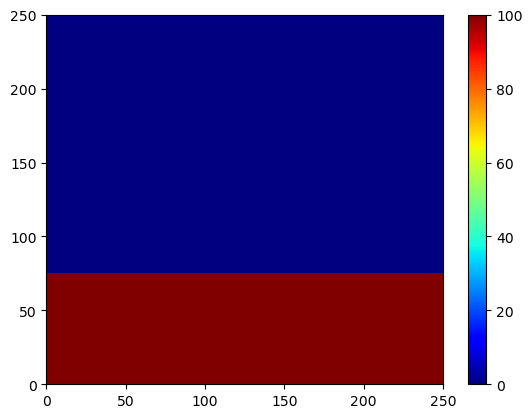

In [354]:
fig, axis = plt.subplots()
pcm = axis.pcolormesh(u, cmap = plt.cm.jet, vmin=0, vmax=100)
plt.colorbar(pcm, ax=axis)


In [355]:
cells = [Cell_2( u, int(nodes/ 2), int( nodes / 2), secretion=True, degradation_area=2) for _ in range(num_cells)]
counter = 0 
cellMarker = []

### Compiled function calculating a time-step update of the diffusion of a chemoattractant according to the heat equation where "heat" is the concentration of the chemoattractant:


$$\frac {\partial C}{\partial t} = \alpha \frac {\partial^2 C}{\partial x^2} $$

This is computed using the explicit Finite-Difference Numerical Method, in the future this should be updated to the Crank-Nicolson method for small time steps to ensure stability or the implicit method for larger time steps

Finite Difference Method: 
$$ u^\prime[x] = \frac{u[x-dx] - 2* u[dx] + u [x + dx]} {dx^2} $$
$$ u^\prime[y] = \frac{u[y-dy] - 2* u[y] + u [x + dy]} {dy^2} $$

In [356]:

@jit(nopython=True)
def calc_grad_np(u):
    w = u.copy()
    w[1:-1, 1:-1] = (
        u[1:-1, 1:-1]
        + alpha * dt * (
            (u[2:, 1:-1] - 2 * u[1:-1, 1:-1] + u[:-2, 1:-1]) / dx**2
            + (u[1:-1, 2:] - 2 * u[1:-1, 1:-1] + u[1:-1, :-2]) / dy**2
        )
    )
    return w

In [357]:
def update_cell(c, u, dx, dy, counter, dt, grid_size):
    
    c.update_pos_grad(u, dx, dy, 0.5, counter, dt, grid_size)

    if c.degRadius > 1:

        x_min, x_max = 0, u.shape[1] - 1
        y_min, y_max = 0, u.shape[0] - 1

        clipped_degArea = np.copy(c.degArea)
        clipped_degArea[:, 0] = np.clip(clipped_degArea[:, 0], y_min, y_max)  # Y-axis
        clipped_degArea[:, 1] = np.clip(clipped_degArea[:, 1], x_min, x_max)  # X-axis

        u[clipped_degArea[:,1], clipped_degArea[:,0]] = u[clipped_degArea[:,1], clipped_degArea[:,0]] / 10


        #u[c.degArea[:,1], c.degArea[:,0]] = u[c.degArea[:,1], c.degArea[:,0]] / 10
    else:
        u[c.pos_x, c.pos_y] =  u[c.pos_x, c.pos_y] / 10
        if c.secrete:
            if c.attractant_secretion_rule():
                u[c.pos_x, c.pos_y] =  u[c.pos_x, c.pos_y] + 40
        
    return c

In [358]:
gradient_history = deque()

In [359]:
start = time.time()

while counter < sim_time : # O(t)

    w = u.copy()
    if cellMarker:
        for mark in cellMarker: # O(n)
            mark.remove()

    u = calc_grad_np(u) 

    tasks = [ delayed (update_cell)(c, u, dx, dy, counter, dt, u.shape) for c in cells ]
        
    
    results = dask.compute(*tasks)

   # print("t: {:.3f} [s], Concentration {:.2f} %".format(counter, np.average(u)))

  #  pcm.set_array(u)
   # axis.set_title("Distribution at t: {:.3f} [s].".format(counter))


    try:
        cellMarker = [axis.plot(cell.points[:,0] , cell.points[:,1], 'wo', markersize=1)[0] for cell in cells]  
    except:
        print("Error in plotting")
        for cell in cells:
            print(cell.points)
        exit(1)
 
  #  plt.pause(0.01)
    counter += dt
    
end = time.time()
FINAL = end - start

print(f'Total Execution Time: {FINAL}')

Total Execution Time: 1.2950549125671387


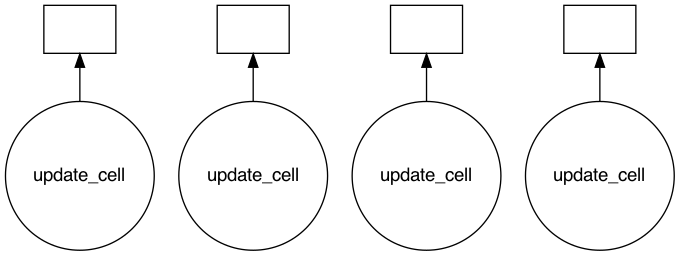

In [360]:
dask.visualize(tasks, finename="compute_graph", type="png")

In [361]:
test_cell = cells[0]

In [362]:
df = test_cell.get_stimulation_stats("df")

In [363]:
stats = [dfs.get_stimulation_stats("merged_merged_merged_df") for dfs in cells]

In [364]:
cell_1 = test_cell
cell_2 = cells[1]

In [365]:
cell_1_pos = cell_1.get_position_history("df")
cell_2_pos = cell_2.get_position_history("df")

In [366]:
cell_2_pos

,time_step,pos_x,pos_y
0,0.0000,125,125
1,0.0128,126,126
2,0.0256,125,127
3,0.0384,126,126
4,0.0512,127,125
...,...,...,...
778,9.9584,73,63
779,9.9712,72,64
780,9.9840,72,64
781,9.9968,71,64


In [367]:
merged_df = pd.merge(cell_1_pos, cell_2_pos, on="time_step", suffixes=("_1", "_2"))

# Compute distance
merged_df["distance"] = np.sqrt(
    (merged_df["pos_x_1"] - merged_df["pos_x_2"])**2 +
    (merged_df["pos_y_1"] - merged_df["pos_y_2"])**2
)

In [368]:
merged_df

,time_step,pos_x_1,pos_y_1,pos_x_2,pos_y_2,distance
0,0.0000,125,125,125,125,0.000000
1,0.0128,125,125,126,126,1.414214
2,0.0256,126,124,125,127,3.162278
3,0.0384,126,123,126,126,3.000000
4,0.0512,125,122,127,125,3.605551
...,...,...,...,...,...,...
778,9.9584,11,30,73,63,70.235319
779,9.9712,12,30,72,64,68.963759
780,9.9840,13,30,72,64,68.095521
781,9.9968,14,29,71,64,66.887966


In [369]:
dx1, dy1 = merged_df['pos_x_1'].diff(), merged_df['pos_y_1'].diff()
dx2, dy2 = merged_df['pos_x_2'].diff(), merged_df['pos_y_2'].diff()

In [370]:
dx1 = merged_df['pos_x_1'].diff().fillna(0)
dy1 = merged_df['pos_y_1'].diff().fillna(0)
dx2 = merged_df['pos_x_2'].diff().fillna(0)
dy2 = merged_df['pos_y_2'].diff().fillna(0)

In [371]:
theta1 = np.arctan2(dy1, dx1)
theta2 = np.arctan2(dy2, dx2)


In [372]:
delta_theta1 = np.abs(np.diff(theta1))
delta_theta2 = np.abs(np.diff(theta2))

In [373]:
threshold = 10  # Define proximity threshold
proximity = merged_df['distance'][:-1] < threshold

In [374]:
# Extract delta_theta when cells are close vs far
delta_close = delta_theta1[proximity]
delta_far = delta_theta1[~proximity]

In [375]:
from scipy.stats import ttest_ind

In [376]:
delta_close

array([0.        , 0.78539816, 0.78539816, 0.78539816, 0.        ,
       0.78539816, 0.78539816, 3.14159265, 3.92699082, 1.57079633,
       1.57079633, 1.57079633, 1.57079633, 3.92699082, 1.57079633,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.78539816, 1.57079633, 1.57079633, 1.57079633,
       3.92699082, 3.14159265, 1.57079633, 3.14159265, 1.57079633,
       2.35619449, 0.        , 3.14159265, 0.        , 2.35619449,
       0.78539816, 1.57079633, 0.78539816, 0.78539816, 0.        ,
       0.        , 0.78539816, 2.35619449, 2.35619449, 0.        ])

In [377]:
stat, p_value = ttest_ind(delta_close, delta_far, equal_var=False)

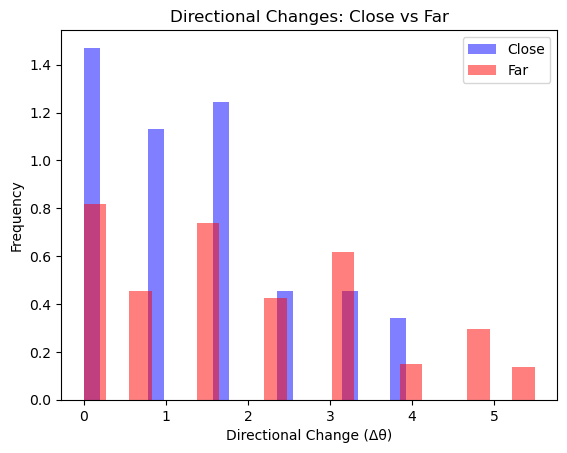

Mean Δθ (Close): 1.31
Mean Δθ (Far): 1.98
T-test p-value: 0.00086


In [378]:
plt.hist(delta_close, bins=20, alpha=0.5, label='Close', color='blue', density=True)
plt.hist(delta_far, bins=20, alpha=0.5, label='Far', color='red', density=True)
plt.xlabel("Directional Change (Δθ)")
plt.ylabel("Frequency")
plt.title("Directional Changes: Close vs Far")
plt.legend()
plt.show()

print(f"Mean Δθ (Close): {np.mean(delta_close):.2f}")
print(f"Mean Δθ (Far): {np.mean(delta_far):.2f}")
print(f"T-test p-value: {p_value:.5f}")

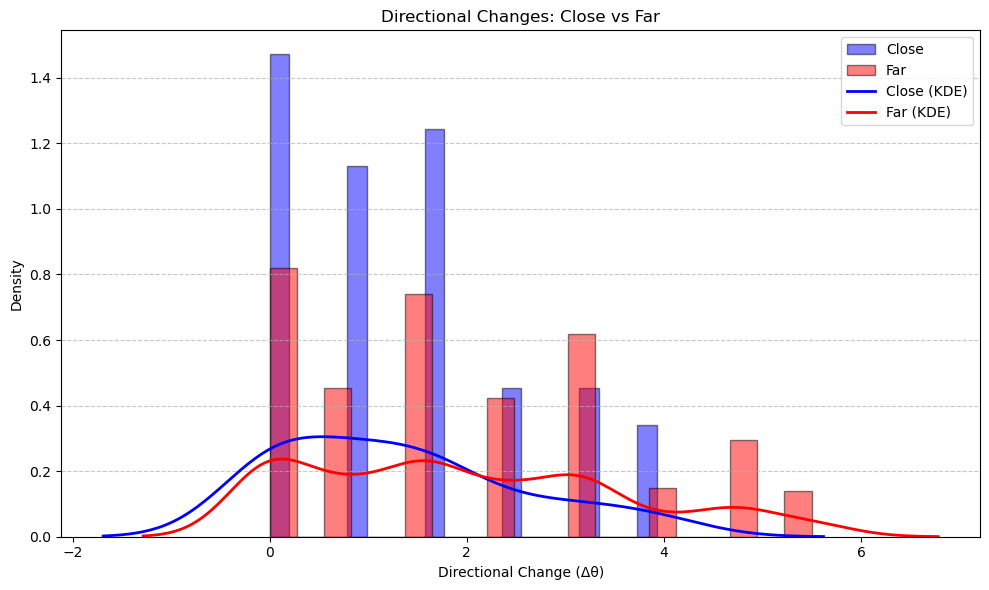

In [379]:
import seaborn as sns

# Plot histograms with better visuals
plt.figure(figsize=(10, 6))

# Histogram with transparency
plt.hist(delta_close, bins=20, alpha=0.5, label='Close', color='blue', density=True, edgecolor='black')
plt.hist(delta_far, bins=20, alpha=0.5, label='Far', color='red', density=True, edgecolor='black')

# Add KDE for smooth comparison
sns.kdeplot(delta_close, color='blue', label='Close (KDE)', linewidth=2)
sns.kdeplot(delta_far, color='red', label='Far (KDE)', linewidth=2)

# Add labels and legend
plt.xlabel("Directional Change (Δθ)")
plt.ylabel("Density")
plt.title("Directional Changes: Close vs Far")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show plot
plt.tight_layout()
plt.show()

In [380]:
dx1 = merged_df['pos_x_1'].diff().dropna().values  # Movement in x for cell 1
dy1 = merged_df['pos_y_1'].diff().dropna().values  # Movement in y for cell 1
dx2 = merged_df['pos_x_2'].diff().dropna().values  # Movement in x for cell 2
dy2 = merged_df['pos_y_2'].diff().dropna().values

In [381]:
from scipy.signal import correlate

In [382]:
cross_corr_x = correlate(dx1, dx2, mode="full")
cross_corr_y = correlate(dy1, dy2, mode="full")

cross_corr_x /= np.linalg.norm(dx1) * np.linalg.norm(dx2)
cross_corr_y /= np.linalg.norm(dy1) * np.linalg.norm(dy2)

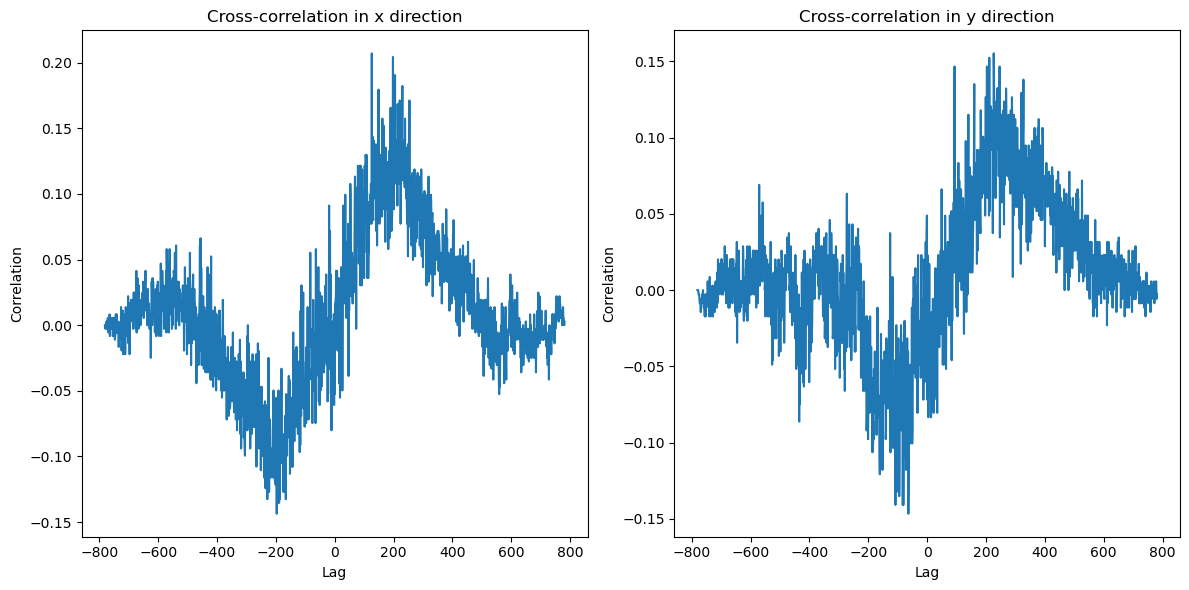

In [383]:
# Create an array for the lag values (time shifts)
lags = np.arange(-(len(dx1)-1), len(dx1))

# Plot the cross-correlation in both directions
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(lags, cross_corr_x)
plt.title("Cross-correlation in x direction")
plt.xlabel("Lag")
plt.ylabel("Correlation")

plt.subplot(1, 2, 2)
plt.plot(lags, cross_corr_y)
plt.title("Cross-correlation in y direction")
plt.xlabel("Lag")
plt.ylabel("Correlation")

plt.tight_layout()
plt.show()

In [384]:
gradient_field_history = list(gradient_history)

In [385]:
gradient_field_history

[]

In [386]:
px.line(df, x = "time_step", y = ["effective_stimulus", "gradient_magnitude"], title = "Stimulation Statsistics")

In [387]:
k_on = 10e2  # M^-1 s^-1#
k_off = 10e3 # s^-1

K_d = k_off / k_on # M

In [388]:
print(K_d)

10.0


In [389]:
test_stim = [getEffectiveStimulus(test_cell.v_max, i, K_d) for i in range(0,101)]

In [390]:
test_arr = [i for i in range(0,101)]

Text(0, 0.5, 'Effective Stimulus $v$')

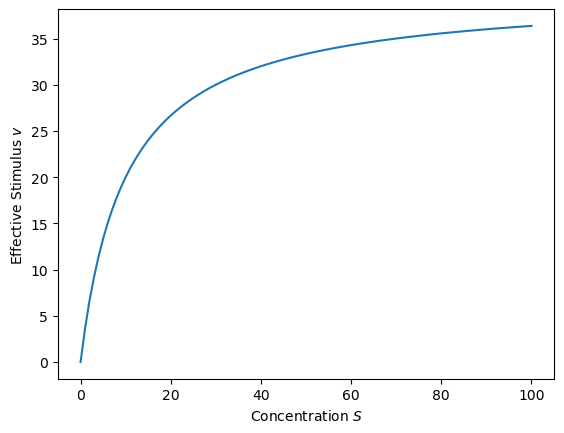

In [391]:
plt.plot(test_arr,test_stim)
plt.xlabel("Concentration $S$")
plt.ylabel("Effective Stimulus $v$")

In [392]:
df.corr()

,time_step,effective_stimulus,gradient_magnitude
time_step,1.000000,0.763269,-0.647590
effective_stimulus,0.763269,1.000000,-0.763885
gradient_magnitude,-0.647590,-0.763885,1.000000


In [393]:
test_cell1 = cells[0].get_position_history(type="df")

In [394]:
test_cell1

,time_step,pos_x,pos_y
0,0.0000,125,125
1,0.0128,125,125
2,0.0256,126,124
3,0.0384,126,123
4,0.0512,125,122
...,...,...,...
778,9.9584,11,30
779,9.9712,12,30
780,9.9840,13,30
781,9.9968,14,29


In [395]:
cell_0_pos_history = np.array(cells[0].get_position_history())
cell_1_pos_history = np.array(cells[1].get_position_history())
cell_2_pos_history = np.array(cells[2].get_position_history())
cell_3_pos_history = np.array(cells[3].get_position_history())


In [396]:
def plot_cell_history(cell_history):
    time_steps = cell_history [:,0]
    x_pos = cell_history [:,2]
    y_pos = cell_history [:,1]

    points = np.array([x_pos, y_pos]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)

    # Create a LineCollection with color mapping
    lc = LineCollection(segments, cmap='viridis', norm=plt.Normalize(time_steps.min(), time_steps.max()))
    lc.set_array(time_steps)
    lc.set_linewidth(2)

    # Plot
    plt.figure(figsize=(8, 6))
    plt.gca().add_collection(lc)
    plt.plot(x_pos, y_pos, color='black', alpha=0.1)
    # Annotate start and end
    plt.scatter(x_pos[0], y_pos[0], color='green', label='Start', zorder=5)
    plt.scatter(x_pos[-1], y_pos[-1], color='red', label='End', zorder=5)

    plt.colorbar(lc, label='Time Step')
    plt.title("Cell Movement Trajectory with Gradient Line (Colored by Time Step)")
    plt.xlabel("X Position")
    plt.ylabel("Y Position")
    plt.grid(True)
    plt.legend()
    plt.show()

In [397]:

def plot_history_2(position_history, ax=None, color=None, cmap='viridis', label='Cell Path'):
    """
    Plots a cell's movement on a 2-Dimensional grid with a gradient line colored by time step

    Parameters:
    - position_history (np.ndarray): Array of shape (n, 3) where each row is [time_step, x, y].
    - ax (matplotlib.axes._axes.Axes, optional): Axis to plot on. If None, a new figure and axis are created.
    - cmap (str, optional): Colormap for the trajectory.
    - label (str, optional): Label for the cell trajectory.
    
    Returns:
    - fig (matplotlib.figure.Figure): The figure object.
    - ax (matplotlib.axes._axes.Axes): The axes object.
    """
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 6))
    else:
        fig = ax.figure

    # Extract time steps, x positions, and y positions
    time_steps = position_history[:, 0]
    x_positions = position_history[:, 2]
    y_positions = position_history[:, 1]

    # Create segments for LineCollection
    points = np.array([x_positions, y_positions]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)

    # Create a LineCollection with color mapping
    lc = LineCollection(segments, cmap=cmap, norm=plt.Normalize(time_steps.min(), time_steps.max()))
    lc.set_array(time_steps)
    lc.set_linewidth(2)

    ax.add_collection(lc)
    ax.plot(x_positions, y_positions, color=color, alpha=0.3)  # Base path with markers for reference

    # Annotate start and end
    ax.scatter(x_positions[0], y_positions[0], label='Start', zorder=5)
    ax.scatter(x_positions[-1], y_positions[-1], label='End', zorder=5)

    ax.set_title("Cell Movement Trajectory with Gradient Line (Colored by Time Step)")
    ax.set_xlabel("X Position")
    ax.set_ylabel("Y Position")
    ax.grid(True)
    ax.legend()

    return fig, ax, lc

In [398]:
cell_0_pos_history[:,1:]

array([[125., 125.],
       [125., 125.],
       [126., 124.],
       ...,
       [ 13.,  30.],
       [ 14.,  29.],
       [ 15.,  28.]])

/var/folders/_4/kt858wtj2111y2396_n7rtsm0000gn/T/ipykernel_53581/3141811289.py:6: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.



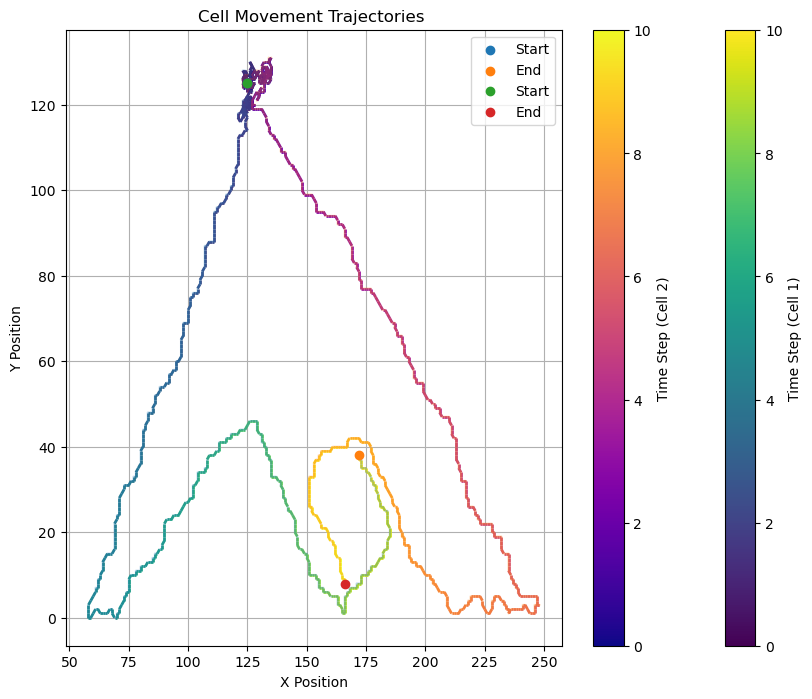

In [399]:
fig, ax = plt.subplots(figsize=(10,8))

trajectories = [ cell_2_pos_history, cell_3_pos_history]

num_trajectories = len(trajectories)
colors = cm.get_cmap('hsv', num_trajectories)


colormaps = ['viridis','plasma', 'winter']

for idx, traj in enumerate(trajectories):
    fig, ax, lc = plot_history_2(traj, ax=ax, cmap=colormaps[idx], label=f'Cell {idx + 1}')
    cbar = plt.colorbar(lc, ax=ax, label=f'Time Step (Cell {idx + 1})')
    cbar.set_label(f'Time Step (Cell {idx + 1})')
    
ax.legend()
plt.title("Cell Movement Trajectories ")
plt.show()

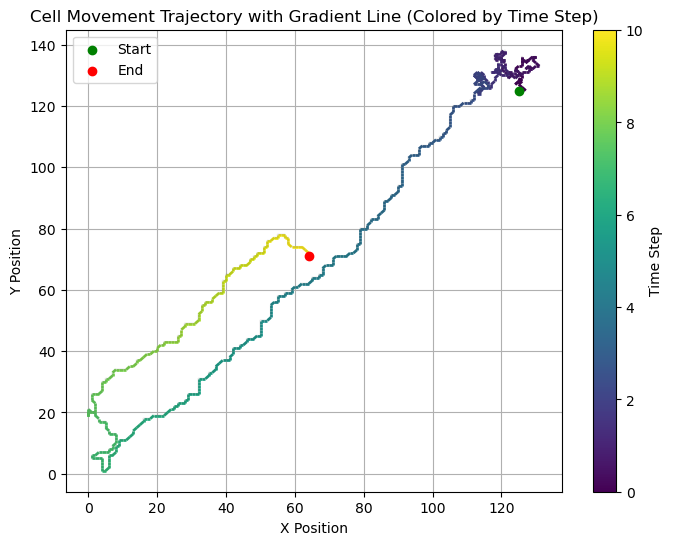

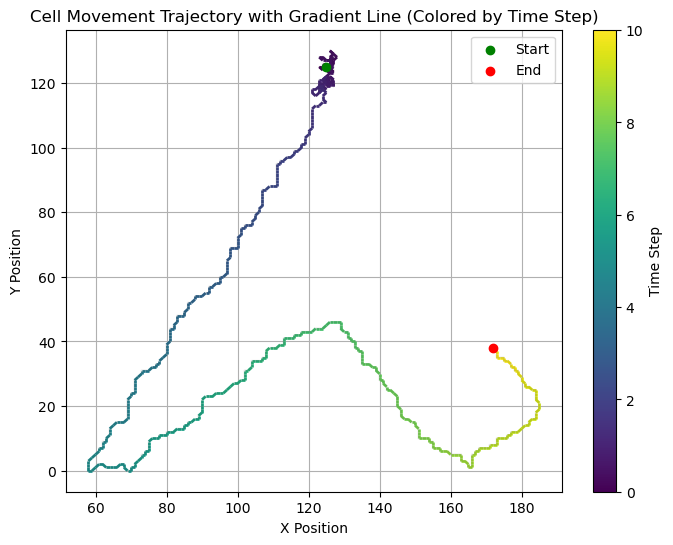

In [400]:
plot_cell_history(cell_1_pos_history)
plot_cell_history(cell_2_pos_history)